<a href="https://colab.research.google.com/github/MathiLogha/ConvolutionalNeuralNetwork/blob/main/cnn_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import TensorBoard
log_folder = './tf/rbf_logs'
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
sample = r"../Datasets/environmental-sound-classification-50/audio/audio/1-100032-A-0.wav"
x,freq = librosa.load(sample)
sr=freq

In [ ]:
print(x.shape)
print(type(x))
print(freq)
print(type(freq))

(110250,)
<class 'numpy.ndarray'>
22050
<class 'int'>


Sound can be played with ipd library as follows.

In [ ]:
import IPython.display as ipd
ipd.Audio(sample)

<Figure size 1000x300 with 0 Axes>

Text(0.5, 1.0, 'Single Bark Wave Plot')

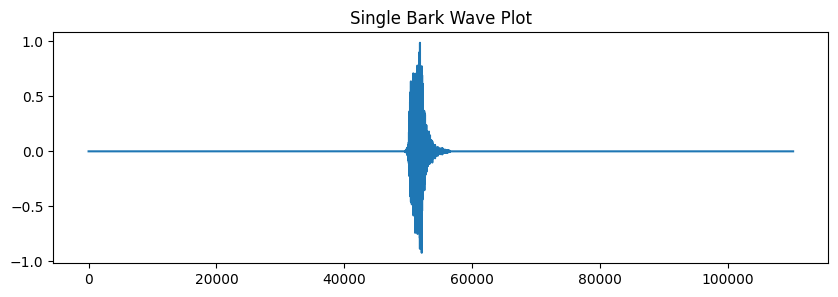

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,3))
plt.title("Single Bark Wave Plot")
plt.plot(x)

For 2nd sample .wav we will use multiple bark of a dog.

<Figure size 2000x800 with 0 Axes>

Text(0.5, 1.0, 'Multi Bark Sound Spectogram')

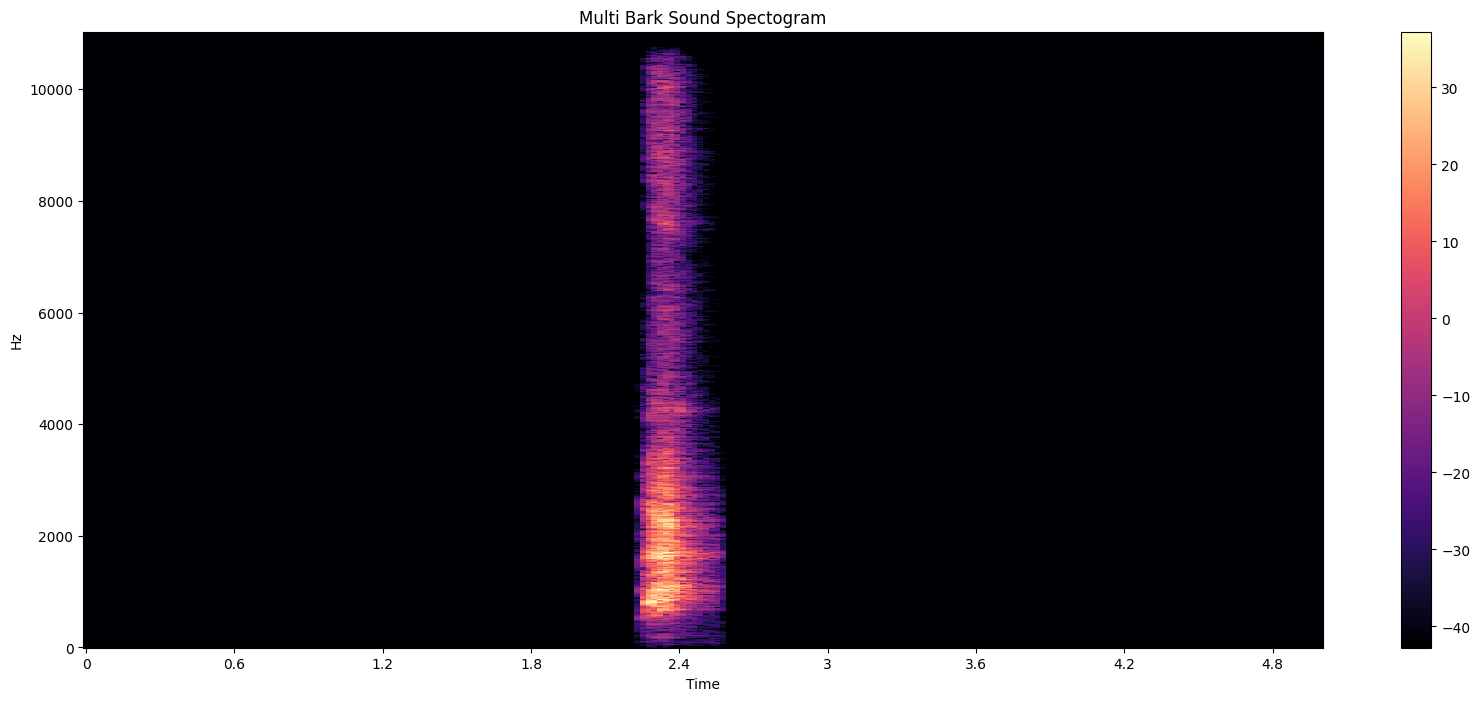

In [ ]:
X=librosa.stft(x) #stft -> Short-time Fourier transform
X_db=librosa.amplitude_to_db(abs(X)) #Translation from amplitude to desibel(db) value
plt.figure(figsize=(20,8))
librosa.display.specshow(X_db, sr=sr,x_axis="time",y_axis="hz")
plt.title("Multi Bark Sound Spectogram")
plt.colorbar()

shape of mfcc: (20, 216)


<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Mel-Frequency Cepstral Coefficients')

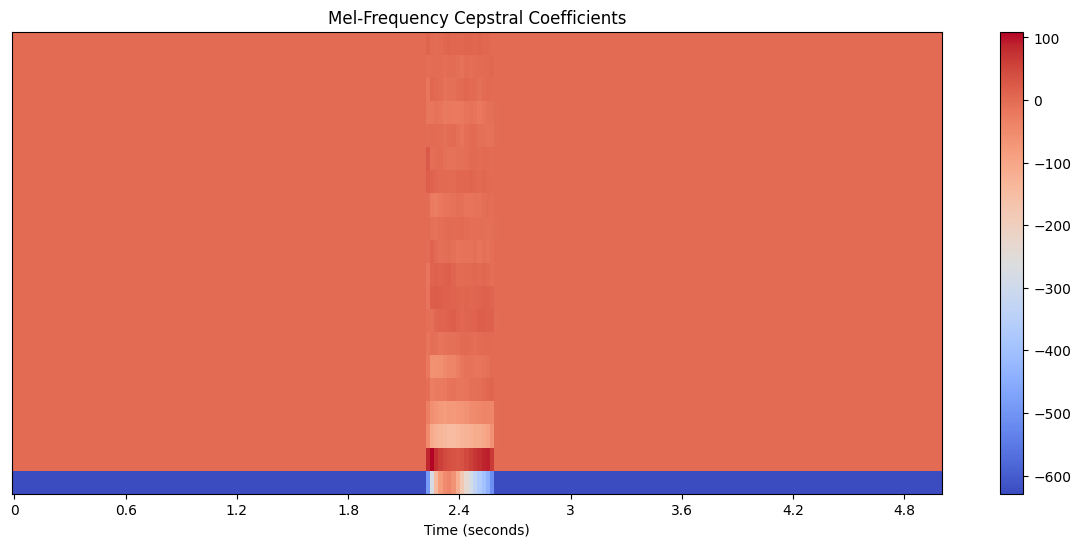

In [ ]:
mfcc=librosa.feature.mfcc(y=x,sr=sr)
print("shape of mfcc:" ,mfcc.shape)

plt.figure(figsize=(15,6))
librosa.display.specshow(mfcc,x_axis="s")
plt.title("Mel-Frequency Cepstral Coefficients")
plt.colorbar()

In [ ]:
CSV_FILE_PATH = "../Datasets/environmental-sound-classification-50/esc50.csv"  # path of csv file
DATA_PATH = "../Datasets/environmental-sound-classification-50/audio/audio/16000/" # path to folder containing audio files

In [ ]:
df = pd.read_csv(CSV_FILE_PATH)
# df.head()
# print("shape of df: ", df.shape)

In [ ]:
df=df.drop(['fold','esc10','src_file','take'], axis=1)

In [ ]:
classes = df['category'].unique()
# print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

# of Classes are:  50


In [ ]:
class_dict = {i:x for x,i in enumerate(classes)}


In [ ]:
#drop duplicates if there are any in filename...
df = df.drop_duplicates(subset=['filename'])

In [ ]:
df['target'] = df['category'].map(class_dict)
df.head()
print("df shape: ", df.shape)

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-100210-A-36.wav,2,vacuum_cleaner
3,1-100210-B-36.wav,2,vacuum_cleaner
4,1-101296-A-19.wav,3,thunderstorm


df shape:  (2000, 3)


In [ ]:
X = []
y = []

In [ ]:
for data in tqdm(df.iterrows(),  desc='Progress'):
    try:
        sig , sr = librosa.load(DATA_PATH+data[1][0])
        mfcc_ = librosa.feature.mfcc(y=sig , sr=sr, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    except:
        pass

Progress: 1942it [00:36, 54.59it/s]/tmp/ipykernel_3621/881876920.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  sig , sr = librosa.load(DATA_PATH+data[1][0])
/home/namachu/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Progress: 2000it [00:36, 54.81it/s]


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(1947, 40, 216)

In [ ]:
y = tf.keras.utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


In [ ]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (1947, 40, 216, 1)
y Shape is:  (1947, 50)


In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [ ]:
INPUTSHAPE = (40,216,1)

In [ ]:


model =  models.Sequential([

                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(50 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

2023-04-26 22:32:43.747005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 22:32:43.753815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 22:32:43.753894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 22:32:43.754418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 214, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 107, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 105, 128)      36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 53, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 53, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 51, 128)        1

In [ ]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
    )

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=40,
            callbacks = [callback,TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)],batch_size=batch_size)

2023-04-26 22:37:13.549453: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-26 22:37:13.549526: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-26 22:37:13.551199: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2023-04-26 22:37:13.551352: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:184] cuptiSubscribe: ignored due to a previous error.
2023-04-26 22:37:13.551371: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2023-04-26 22:37:13.551378: E tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1715] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2023-04-26 22:37:13.551443: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-26 22:37:13.

Epoch 1/40
  1/195 [..............................] - ETA: 25s - loss: 0.3094 - acc: 0.8750

2023-04-26 22:37:13.758607: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-26 22:37:13.758673: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-26 22:37:13.758803: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:133] cuptiGetTimestamp: ignored due to a previous error.
2023-04-26 22:37:13.758819: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:184] cuptiSubscribe: ignored due to a previous error.
2023-04-26 22:37:13.758823: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2023-04-26 22:37:13.758827: E tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1715] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2023-04-26 22:37:13.879541: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-04-26 22:3

195/195 [==============================] - 4s 21ms/step - loss: 0.3704 - acc: 0.8831 - val_loss: 2.0296 - val_acc: 0.5718
Epoch 2/40
195/195 [==============================] - 4s 19ms/step - loss: 0.3204 - acc: 0.8992 - val_loss: 2.0180 - val_acc: 0.5795
Epoch 3/40
195/195 [==============================] - 4s 19ms/step - loss: 0.3868 - acc: 0.8831 - val_loss: 1.8530 - val_acc: 0.6179
Epoch 4/40
195/195 [==============================] - 4s 18ms/step - loss: 0.3043 - acc: 0.9056 - val_loss: 2.2178 - val_acc: 0.5692
Epoch 5/40
195/195 [==============================] - 4s 19ms/step - loss: 0.2215 - acc: 0.9313 - val_loss: 2.4901 - val_acc: 0.5385
Epoch 6/40
195/195 [==============================] - 4s 19ms/step - loss: 0.3043 - acc: 0.9069 - val_loss: 2.1229 - val_acc: 0.6077
Epoch 7/40
195/195 [==============================] - 4s 19ms/step - loss: 0.3054 - acc: 0.9075 - val_loss: 2.4226 - val_acc: 0.6026
Epoch 8/40
195/195 [==============================] - 4s 19ms/step - loss: 0.298

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

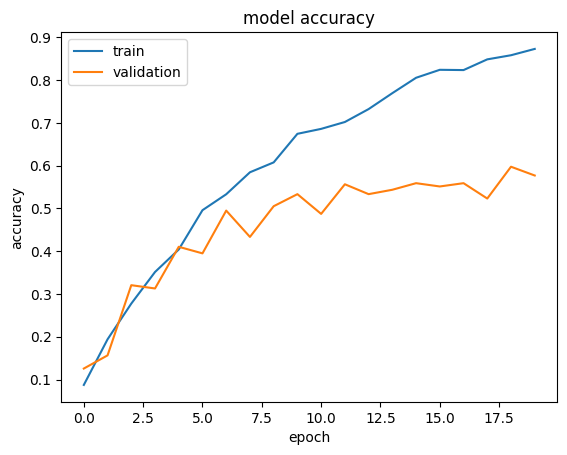

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

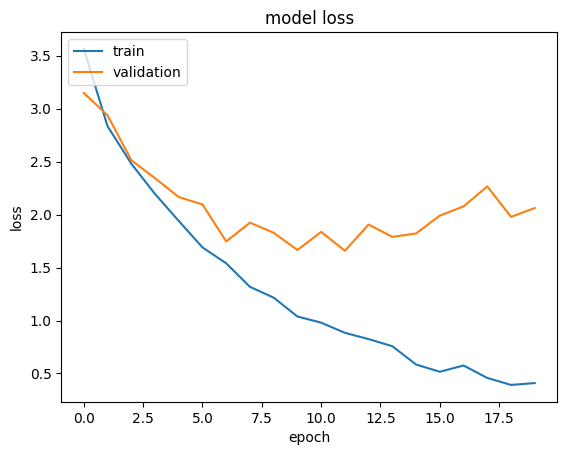

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir={log_folder}